In [17]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from  torch.nn.functional import one_hot
import h5py
from sklearn.utils import shuffle
import sys
import datetime as dt
import copy
from torchview import draw_graph

from dataframework.src.datasets.vpicdataset import VPICDataset

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

dtype = torch.double
   
# Get functions from other notebooks
%run /tigress/kendrab/analysis-notebooks/preproc_utils.ipynb
%run /tigress/kendrab/analysis-notebooks/eval_utils.ipynb

Using cpu device


In [18]:
# File name details
model_file = "/tigress/kendrab/analysis-notebooks/model_outs/14-06-24/F143444_modelfile.tar"
file_num = 9  # so it is part of the testing dataset
file = f'/scratch/gpfs/kendrab/dataset_vpic_runs/perturbed/21032023/output{file_num}/data.h5'
writepath = '/tigress/kendrab/analysis-notebooks/model_outs/14-06-24/results_pics_F'
modelpic_file = writepath+'/modelpic.pdf'

zooms = [[-np.inf,np.inf], [-20, 20]]
time_idx = 20 #the time index we are processing rn
kwargs = {'get_vars' : ['bx','by','bz','jy','vz','ex','ey','ez']}

### Paste model parameters here

In [19]:
model_name = "F"

# hyperparameters
padding_length = 39  # amount of data on each side of each segment for additional info
stride = 11  # size (and therefore spacing) of each segment
input_length = stride + 2*padding_length
kernel_size = 3
pool_size = 5
out_channels = 36  # like 'filters' in keras
thinning_factor = 0.5445523804834298
learning_rate = 0.0025266393119259896
epochs = 24
dropout_fraction = 0.11224778904622225
num_conv = 1

# other parameters
batch_size = 11  # idk what this should be for best performance 
threshold = 0.5

### Paste model class here (and supporting functions)

In [20]:
def repeat_layers_n_times(layer_list, n):  # this instead of something simpler to be absolutely sure the layers are different objects and not repeating the same one
    new_layer_list = []
    for i in range(n):
        for layer in layer_list:
            new_layer_list.append(copy.deepcopy(layer))
    return new_layer_list

In [21]:
#TODO feed hyperparameters into __init__
class ModelF(nn.Module):
    """ 1D CNN Model """
    def __init__(self):  # TODO change optuna params from globals to inputs to init
        super().__init__()
        # define these all separately because they will get different weights
        # consider smooshing these together into one convolution with in_channels=6. Idk if a good idea
        self.bx_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))
        self.by_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))
        self.bz_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))
        self.ex_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))
        self.ey_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))
        self.ez_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))
        self.jy_layers = nn.Sequential(*repeat_layers_n_times([nn.LazyConv1d(out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(), nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction)], num_conv))

        self.post_merge_layers = nn.Sequential(nn.Conv1d(out_channels, out_channels*2, kernel_size,
                                                                     padding='valid'), nn.ReLU(),
                                                           nn.MaxPool1d(pool_size), nn.Dropout(p=dropout_fraction),
                                                nn.Flatten(),
                                                nn.LazyLinear(stride))


    def forward(self, bx, by, bz, ex, ey, ez, jy):
        bx_proc = self.bx_layers(bx)
        by_proc = self.by_layers(by)
        bz_proc = self.bz_layers(bz)
        ex_proc = self.ex_layers(ex)
        ey_proc = self.ey_layers(ey)
        ez_proc = self.ez_layers(ez)
        jy_proc = self.jy_layers(jy)
        combined = (bx_proc + by_proc + bz_proc + ex_proc + ey_proc + ez_proc + jy_proc)/6.
        logits = self.post_merge_layers(combined)

        return logits

In [22]:
def test_loop(dataloader, model, loss_fn, threshold = 0.5):
    model.eval()
    pred_list = []
    size = len(dataloader.dataset)  # number of samples
    stride = dataloader.dataset[0][0].shape[-1]
    tot_points = size*stride
    num_batches = len(dataloader)
    test_loss_sum, correct = 0, 0

    with torch.no_grad():
        for _, _, bx, by, bz, ex, ey, ez, jy, _, _, y in dataloader:
            pred = model(bx, by, bz, ex, ey, ez, jy)
            pred_list.append(pred.cpu().numpy())
            test_loss_sum += loss_fn(pred, y).item()  # .item() fetches the python scalar
            # number of correct per-point predictions
            correct += ((pred > threshold) == y).type(torch.float).sum().item()
    tot_pred = np.concatenate(pred_list, axis=0)
    test_loss_sum /= num_batches
    correct /= tot_points
    print(f"Test Error: \n Accuracy: {(100*correct):>0.5f}%, Avg loss: {test_loss_sum:>8f} \n")    
    return tot_pred

### Restore the model

In [23]:
model = ModelF().to(device=device, dtype=torch.double)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

checkpoint = torch.load(model_file)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_fn = checkpoint['loss_fn']

model.eval()  # set to correct mode to get the correct results

# Save a visualization of the model
mock_data = torch.ones((batch_size, 1, input_length), dtype=dtype)
dot = draw_graph(model, input_data=[mock_data for i in range(7)], roll=True)
dot.visual_graph.graph_attr['size'] = '8,11'
dot.visual_graph.render(outfile=modelpic_file,format=modelpic_file[-3:])

/home/kendrab/.conda/envs/torch-env/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


'/tigress/kendrab/analysis-notebooks/model_outs/14-06-24/results_pics_F/modelpic.pdf'

### Load and preprocess the data to feed into the model

In [270]:
oned_path = f"/tigress/kendrab/21032023/{file_num}/new_better/100samples_idx{time_idx}_bxbybzjyvzexeyez.hdf5"

with h5py.File(oned_path, 'r') as oned_file:
    s_list = list(oned_file['s'][:])
    bx_list = list(oned_file['bx_mms_smooth'][:])
    by_list = list(oned_file['by_mms'][:])
    bz_list = list(oned_file['bz_mms_smooth'][:])
    ex_list = list(oned_file['ex_mms'][:])
    ey_list = list(oned_file['ey_mms'][:])
    ez_list = list(oned_file['ez_mms'][:])
    jy_list = list(oned_file['jy_mms'][:])
    vx_list = list(oned_file['vx_mms'][:])  # vx_mms is simulation vx  thus the filename 
    x0_list = list(oned_file['x_mms'][:])
    x1_list = list(oned_file['z_mms'][:])
    topo_list_tmp = list(oned_file['topo'][:])
    for i in range(len(topo_list_tmp)):  # I tried to vectorize this but I didn't get it to work
        topo_list_tmp[i] = torch.from_numpy(topo_list_tmp[i].astype(int) % 2)  # cat 0,2 are not plasmoids, cat 1,3 are
    topo_list = topo_list_tmp


In [271]:
# chunk into sliding windows
# NOTE TOPO HAS DIFFERENT SEGMENT LENGTHS THAN THE INPUTS (stride vs. 2*padding+stride)
s = batch_subsects(s_list, input_length, stride)  # not going through training so don't need to shape right
bx = np.expand_dims(batch_subsects(bx_list, input_length, stride),1)
by = np.expand_dims(batch_subsects(by_list, input_length, stride),1)
bz = np.expand_dims(batch_subsects(bz_list, input_length, stride),1)
ex = np.expand_dims(batch_subsects(ex_list, input_length, stride),1)
ey = np.expand_dims(batch_subsects(ey_list, input_length, stride),1)
ez = np.expand_dims(batch_subsects(ez_list, input_length, stride),1)
jy = np.expand_dims(batch_subsects(jy_list, input_length, stride),1)
vx = np.expand_dims(batch_subsects(vx_list, input_length, stride),1)
x0 = batch_unpadded_subsects(x0_list, padding_length, stride)
x1 = batch_unpadded_subsects(x1_list, padding_length, stride)
topo = batch_unpadded_subsects(topo_list, padding_length, stride)

print(s.shape,bx.shape,by.shape,bz.shape,jy.shape,vx.shape,x0.shape,x1.shape,topo.shape)

(3757, 89) (3757, 1, 89) (3757, 1, 89) (3757, 1, 89) (3757, 1, 89) (3757, 1, 89) (3757, 11) (3757, 11) (3757, 11)


In [272]:
s = torch.from_numpy(s).to(device, dtype=dtype)
bx = torch.from_numpy(bx).to(device, dtype=dtype)
by = torch.from_numpy(by).to(device, dtype=dtype)
bz = torch.from_numpy(bz).to(device, dtype=dtype)
ex = torch.from_numpy(ex).to(device, dtype=dtype)
ey = torch.from_numpy(ey).to(device, dtype=dtype)
ez = torch.from_numpy(ez).to(device, dtype=dtype)
jy = torch.from_numpy(jy).to(device, dtype=dtype)
vx = torch.from_numpy(vx).to(device, dtype=dtype)
x0 = torch.from_numpy(x0).to(device, dtype=dtype)
x1 = torch.from_numpy(x1).to(device, dtype=dtype)
topo = torch.from_numpy(topo).to(device, dtype=dtype)
oned_dset =  TensorDataset(s, bx, by, bz, ex, ey, ez, jy, vx,
                              x0, x1, topo)
oned_dl = DataLoader(oned_dset, batch_size = batch_size)

### get 2d data

In [273]:
def mtail_transform(sim_data):  # TODO FIX THIS  # From 1d_sampling notebook
    """ The geometry of the simulation is different wrt the magnetotail. Keeping y the same, bx will be
    the mtail's 'bz' and bz will be the mtails 'bx'.
    This function is for simulations WITHOUT y spatial dimensions
    THIS IS NOT A GOOD GENERALIZABLE FUNCTION!!!! REUSE WITH EXTREME CAUTION!!!
    This is for rxn geometry in vpic with Bz positive for x>0 and negative for x<0.
    If it is the opposite, need to do a different transform to get the reconnection to line up w/ gsm directions
    """
    # vpic +x -> GSM +z
    # vpic +z -> GSM +x
    # vpic +y -> GSM -y
    # meshes now in order x, z instead of z, x (renaming coords)
    # for vector variables ax, ay, az:
    # rename ax -> az_mms
    # ay_mms = -ay
    # rename az -> ax_mms
    sim_data.variables['bz_mms'] = sim_data.variables.pop('bx')
    sim_data.variables['bz_mms_smooth'] = sim_data.variables.pop('bx_smooth')
    sim_data.variables['by_mms'] = sim_data.variables.pop('by')
    sim_data.variables['by_mms'].data *= -1
    sim_data.variables['bx_mms'] = sim_data.variables.pop('bz') 
    sim_data.variables['bx_mms_smooth'] = sim_data.variables.pop('bz_smooth') 
    sim_data.variables['vx_mms'] = sim_data.variables.pop('vz')
    sim_data.variables['jy_mms'] = sim_data.variables.pop('jy')
    sim_data.variables['jy_mms'].data *= -1    
    sim_data.variables['ez_mms'] = sim_data.variables.pop('ex')
    sim_data.variables['ey_mms'] = sim_data.variables.pop('ey')
    sim_data.variables['ey_mms'].data *= -1
    sim_data.variables['ex_mms'] = sim_data.variables.pop('ez') 
    
    # update variable names for everyone
    for key in sim_data.variables.keys():
        print(f"label {sim_data.variables[key].label} becoming {key}")
        sim_data.variables[key].label = key

In [274]:
sim_dset = VPICDataset(vpicfiles=[file,''], **kwargs)
desired_time = sim_dset.timeseries[time_idx]
dt = sim_dset.timeseries[1] - sim_dset.timeseries[0]
onetime_dset = sim_dset.ndslice(timelims=[desired_time - dt/2, desired_time + dt/2])
onetime_dset.find_structures(b1_name='bz', b2_name='bx', wrap=True)
zoomed_dset = onetime_dset.ndslice(zooms=zooms)
mtail_transform(zoomed_dset)

NO PARAMS ADDED, FUNCTIONALIITY NOT ADDED YET!!!! SORRY
parameter filename = /scratch/gpfs/kendrab/dataset_vpic_runs/perturbed/21032023/output9/data.h5
Added bx Variable
Added by Variable
Added bz Variable
Added jy Variable
Added vz Variable
Added ex Variable
Added ey Variable
Added ez Variable
Finding structures at simulation time 19.995365142822266
parameter d_per_de = 4
Added bz_smooth Variable
Added bx_smooth Variable
Added flux_fn Variable
Number of nulls:  20
parameter x_coords = [[ 242.20368245  582.76954903]
 [ 764.89701954  516.73935864]
 [1249.77256801  574.55024138]
 [1615.37448297  544.47433802]
 [1857.05304506  581.32510894]
 [2104.43887599  541.05737801]
 [2565.12030747  568.68373692]
 [2882.43997583  576.79697997]
 [3636.8212504   620.14640343]
 [4220.75296504  520.99410356]]
parameter o_coords = [[  85.65343981  585.54146253]
 [ 405.80411265  545.10953211]
 [1234.38149449  577.16659483]
 [1292.34302962  568.37798891]
 [1684.95284988  557.597601  ]
 [1956.22095909  573.4

### get the model predictions

In [275]:
x0_loc = []
x1_loc = []
pred_correct = []
size = len(oned_dl.dataset)  # number of samples
tot_points = size*stride
num_batches = len(oned_dl)

with torch.no_grad():
    for _, bx, by, bz, ex, ey, ez, jy, vx, x0, x1, y in oned_dl:
        pred = model(bx, by, bz, ex, ey, ez, jy)
        # correct per-point predictions
        pred_correct.append(((pred > threshold) == y).numpy().flatten())
        x0_loc.append(x0.flatten())
        x1_loc.append(x1.flatten())
pred_correct = np.concatenate(pred_correct, axis=0)
x0_loc = np.concatenate(x0_loc, axis=0)
x1_loc = np.concatenate(x1_loc, axis=0)
x0_right = x0_loc[pred_correct]
x1_right = x1_loc[pred_correct]
x0_wrong = x0_loc[~pred_correct]
x1_wrong = x1_loc[~pred_correct]

### make the actual picture

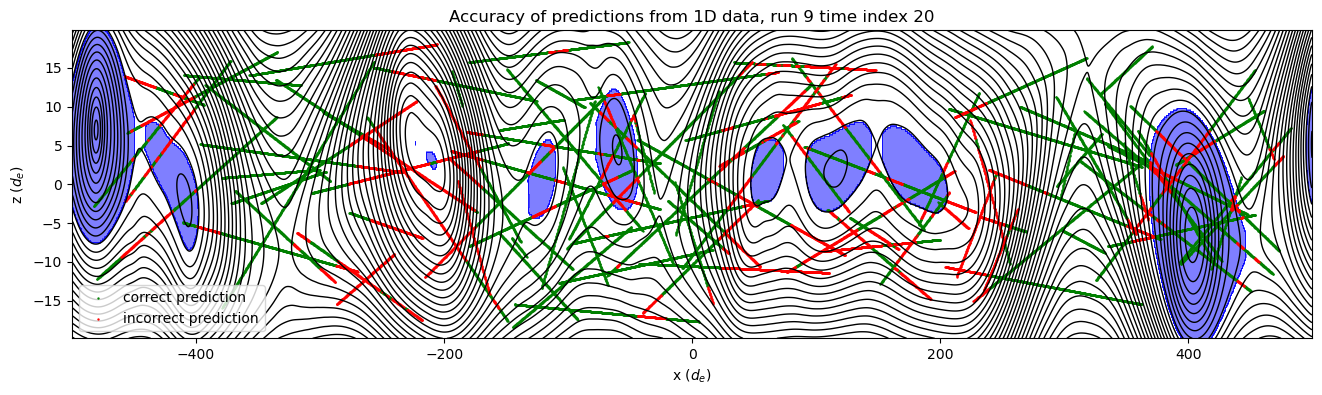

In [276]:
%matplotlib inline

flux_fn = zoomed_dset.variables['flux_fn']
plasmoids = zoomed_dset.variables['o_structures']

fig, ax = plt.subplots(figsize=(16,4))
X,Y = np.meshgrid(*flux_fn.mesh, indexing='ij')
ax.contourf(X, Y, plasmoids.data[0], alpha=0.5, cmap = matplotlib.colors.ListedColormap(['white', 'blue'])) # bdys left right auto up
ax.contour(X, Y, flux_fn.data[0], levels=50, colors='black', linewidths=1) # dashed lines mean flux_fn negative
ax.scatter(x0_right, x1_right, s=2, marker='.', color='green', label='correct prediction')
ax.scatter(x0_wrong, x1_wrong, s=2, marker='.', color='red', label='incorrect prediction')
ax.legend()
ax.set(title=f"Accuracy of predictions from 1D data, run {file_num} time index {time_idx}", xlabel=r"x ($d_e$)", ylabel=r"z ($d_e$)")
plt.show()
fig.savefig(writepath+f'/run{file_num}idx{time_idx}.svg')
plt.close(fig='all')